# HEX algorithm **Kopuru Vespa Velutina Competition**

**XGBoost model**

Purpose: Predict the number of Nests in each of Biscay's 112 municipalities for the year 2020.

Output: *(WaspBusters_20210609_batch_XGBmonths_48019prodigal.csv)*

@authors:
* mario.bejar@student.ie.edu
* pedro.geirinhas@student.ie.edu
* a.berrizbeitia@student.ie.edu
* pcasaverde@student.ie.edu

## Import the Data & Modules

In [48]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import shap

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13, 8) # to set figure size when ploting feature_importance

# XGBoost -------------------------------
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.model_selection import GridSearchCV

In [49]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [50]:
# Importing datasets

queen_train = pd.read_csv("../Feeder_months/WBds03_QUEENtrainMonths.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_months/WBds03_QUEENpredictMonths.csv", encoding="utf-8") #2020 prediction df
#queen_clusters = pd.read_csv("../Feeder_months/WBds_CLUSTERSnests.csv",sep=",")
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

## Clean the Data

### Filter for the assumptions (Clusters & Relevant Municipalities)

In [51]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')

In [52]:
# Remove the Municipalities to which we did not assign a Cluster, since there was no reliable data for us to predict -> Bilbao

queen_train = queen_train.loc[queen_train.municip_code != 48020,:].copy()
queen_predict = queen_predict.loc[queen_predict.municip_code != 48020,:].copy()

### Arrange data into a features matrix and target vector

In [53]:
# selecting the train X & y variables

# "y" will be the response variable (filter the number of wasp nests - "waspbust_id")  
y = queen_train.NESTS

# "X" will be the explanatory variables. Remove response variable and undesired categorical columns such as (municip code, year, etc...)
X = queen_train.iloc[:,4:-10].drop(["station_code"],axis=1).copy()
X["cluster"] = queen_train.Cluster.copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and undesired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.iloc[:,4:-10].drop("station_code",axis=1).copy()
queen_predict2020["cluster"] = queen_predict.Cluster.copy()

Check if the shape of the features and their labels match or if there are errors raised

In [54]:
# Perform checks of features labels & their shapes

assert queen_predict2020.shape[1] == X.shape[1], "Error: Number of columns do not match!"
assert (queen_predict2020.columns == X.columns).any(), "Error: Columns labels do not match"
assert y.shape == (222,), "Error: y shape is incorrect!"

## Model Step 1: Finding out the Relevant Variables 

### Scale the Data for better Regressions

In [55]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [56]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [57]:
# selecting the XGBoost model and fitting with the train data for each cluster

model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

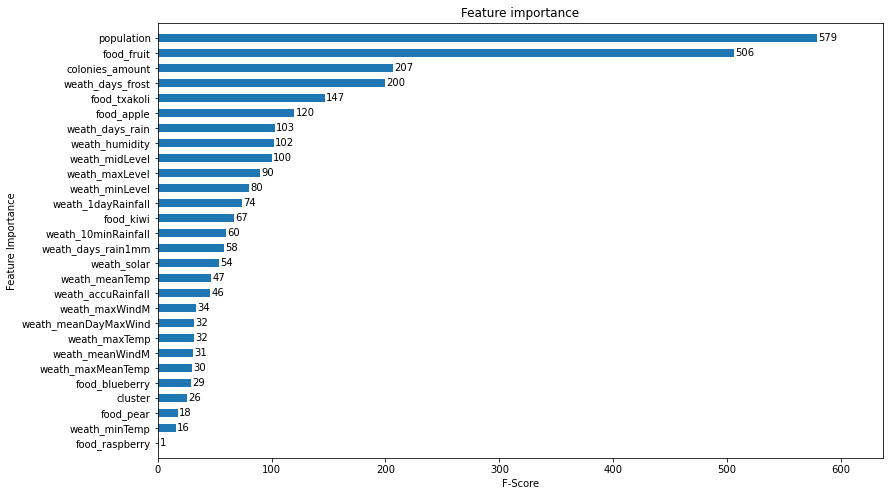

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


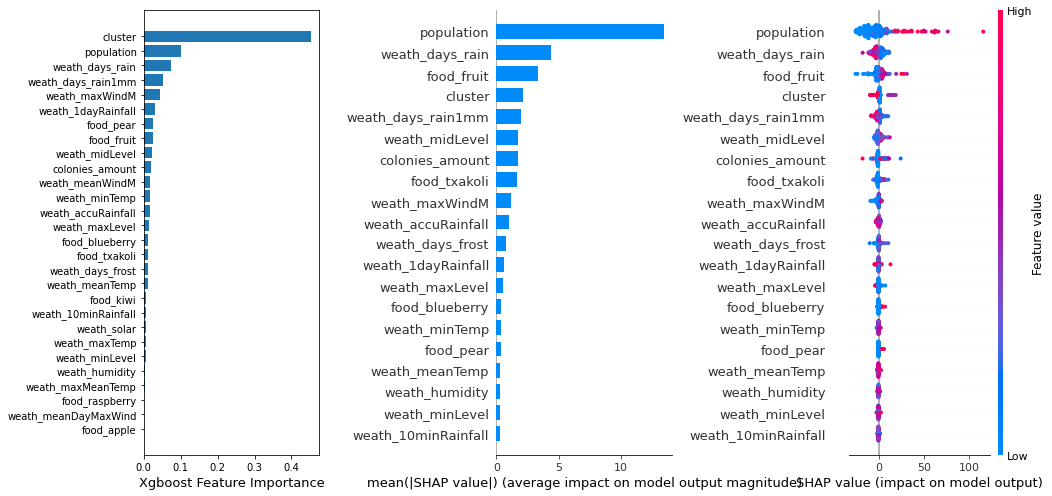

In [58]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

# In built plot method from XGBoost
plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

plt.figure(figsize=(15,7))

# Feature importance from model.feature_importances built-in attribute
sorted_idx = model.feature_importances_.argsort()

plt.subplot(1,3,1)
plt.barh(X_scaled.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance", fontsize=13)

# Shap library Summaries
# Shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

plt.subplot(1,3,2)
shap.summary_plot(shap_values, X_scaled, plot_type="bar", plot_size=None, show=False)

plt.subplot(1,3,3)
shap.summary_plot(shap_values, X_scaled, plot_size=None, show=False)

plt.subplots_adjust(wspace=10.0)
plt.tight_layout()
plt.show()

In [59]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables

X = queen_train.loc[:, ["population", "food_fruit", "colonies_amount", "weath_days_frost", "food_txakoli", "Cluster"]].copy()
X =  np.ascontiguousarray(X) # This line converts X to contiguous so XGBoost is not forced to convert it itself => optimize model speed and memory consumption

queen_predict2020 = queen_predict.loc[:, ["population", "food_fruit", "colonies_amount", "weath_days_frost", "food_txakoli", "Cluster"]].copy()
queen_predict2020 = np.ascontiguousarray(queen_predict2020) # This line converts X to contiguous so XGBoost is not forced to convert it itself => optimize model speed and memory consumption

## Model Step 2: Prediction of 2020 Nests

**Note: Variables are no longer scaled**

### Choose a class of model by importing the appropriate estimator class & Relevant Hyperparameters

In [60]:
# selecting the XGBoost model and fitting with the train data

xgb = XGBRegressor()

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

**WARNING: TIME CONSUMING!**

In [61]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              #"objective":["reg:squarederror"],
              "learning_rate": [0.15,0.3,0.50], 
              "max_depth": [7,8,9],
              "min_child_weight": [0.5,1,1.5],
              "subsample": [0.3,0.5,1],
              "colsample_bytree": [0.7,0.8,1],
              "n_estimators": [50,100,200],
              }

grid = GridSearchCV(xgb,param_grid,cv=2)

#2) Fitting the model with our desired data and check for best results
grid.fit(X, y)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

grid.cv_results_

The number homogeneous splits conducted by GridSearchCV are: 2.
The best hyperparameters found were: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 0.5, 'n_estimators': 200, 'subsample': 1}.
The best score found was: 0.2333608912456958.


{'mean_fit_time': array([0.05103076, 0.04679894, 0.07347751, 0.08643031, 0.09877574,
        0.11662865, 0.16045785, 0.20133293, 0.18913138, 0.05323887,
        0.04672468, 0.05870509, 0.08953118, 0.11546755, 0.12483656,
        0.16539907, 0.20070338, 0.22672284, 0.05132425, 0.05163717,
        0.05302966, 0.08206403, 0.08927727, 0.09761763, 0.164868  ,
        0.15799201, 0.18990123, 0.03669846, 0.04428303, 0.06704879,
        0.08839178, 0.09183729, 0.11652076, 0.1709516 , 0.19049037,
        0.27897823, 0.07061768, 0.04551506, 0.06982243, 0.09724569,
        0.10499775, 0.13662958, 0.1981591 , 0.19539666, 0.23993182,
        0.04440975, 0.04791689, 0.04476833, 0.0819515 , 0.09035861,
        0.09769225, 0.15076172, 0.16190588, 0.20949066, 0.05337119,
        0.05322087, 0.07834005, 0.08564925, 0.10996807, 0.14927566,
        0.14716053, 0.21705949, 0.30592287, 0.05659294, 0.06220341,
        0.07315493, 0.10570943, 0.12031436, 0.15468848, 0.17883098,
        0.19898307, 0.26830125,

**Interpretation of Results:**

- **`mean_test_score`: shows the result for each model iteration.**
    - In this case 


- **`split_0`, `split_1`,etc: Check results in 1st,2nd, 3rd split, etc.**
    - In this case
    


- **`std_test_score` : to check if the model is robust, meaning if we consistently obtained good results or not (high standard deviation).**
    - In this case
    
 **Note: Better to run it 3 times with different homogeneous splits, instead of just 1 split.**

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [62]:
# make a prediction using the best hyperparameters from GridSearchCV (can be retrieved in ".best_estimator_")

prediction_2020 = grid.best_estimator_.predict(queen_predict2020)

## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [63]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = prediction_2020

In [64]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48020],\
             "NOMBRE MUNICIPIO":["Bilbao"],\
             "NIDOS 2020":[0]})

In [65]:
HEX = queen_predict.loc[:,["municip_code","municip_name_x","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [66]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2614


'All Municipality Names and Codes to be submitted match the Template'

In [32]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [ ]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210609_batch_XGBmonths_48019prodigal.csv", index=False)